# Occupazione della stanza

Per prima cosa iniziamo a recuperare il dataset

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

X = pd.read_csv('./data/datatraining.txt')

Definiamo tre palette: una con i colori saturi, una con i colori desaturati e una con i colori scuri

In [3]:
palette_saturated = [
    '#e41a1c',  # rosso
    '#377eb8',  # blu
    '#4daf4a',  # verde
    '#984ea3',  # viola
    '#ff7f00',  # arancio
    '#ffff33',  # giallo
    '#a65628'   # marrone
]

# Palette 2: colori non saturi / pastellati (soft, meno contrasto cromatico ma distinti per tonalità)
palette_pastel = [
    '#fbb4ae',  # rosa chiaro
    '#b3cde3',  # azzurro chiaro
    '#ccebc5',  # verde chiaro
    '#decbe4',  # lilla chiaro
    '#fed9a6',  # pesca chiaro
    '#ffffcc',  # giallo pallido
    '#e5d8bd'   # beige chiaro
]

# Palette 3: colori scuri (contrasto per background chiaro, buoni per elementi pesanti)
palette_dark = [
    '#08306b',  # blu scuro
    '#00441b',  # verde scuro
    '#67000d',  # rosso scuro
    '#4a1486',  # viola scuro
    '#8c2d04',  # arancio scuro / marrone
    '#253494',  # indaco scuro
    '#2b2b2b'   # grigio scuro
]

Quindi andiamo a creare una nuova feature che indica il giorno della settimana (facciamo un mapping con i nomi dei giorni in italiano)

In [4]:
X['date'] = pd.to_datetime(X['date'], format='mixed')
X['weekday'] = X['date'].dt.day_name()
mapping = {
    'Monday':'Lunedì','Tuesday':'Martedì','Wednesday':'Mercoledì',
    'Thursday':'Giovedì','Friday':'Venerdì','Saturday':'Sabato','Sunday':'Domenica'
}
order = ['Lunedì','Martedì','Mercoledì','Giovedì','Venerdì','Sabato','Domenica']
X['weekday'] = X['weekday'].map(mapping)

Visualizziamo il numero di presenze per ogni giorno della settimana

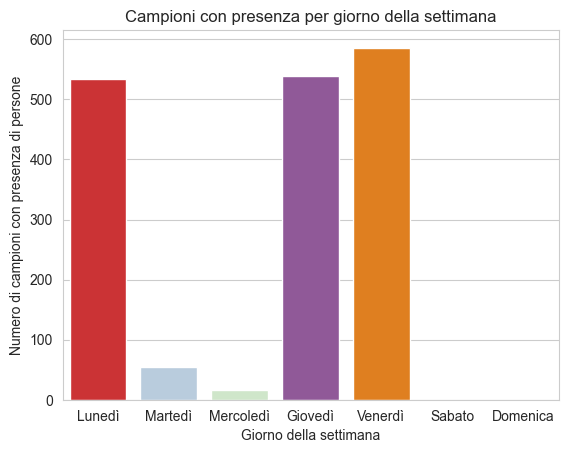

In [5]:
counts = X.groupby('weekday')['Occupancy'].sum()


highlight_days = ['Lunedì','Giovedì', 'Venerdì']

colors_map = {
    day: (palette_saturated[i] if day in highlight_days else palette_pastel[i])
    for i, day in enumerate(order)
}

sns.barplot(x=counts.index, y=counts.values, order=order, hue=counts.index, palette=colors_map)
plt.xlabel('Giorno della settimana')
plt.ylabel('Numero di campioni con presenza di persone')
plt.title('Campioni con presenza per giorno della settimana')
plt.show()

Notiamo dal barchart che si ha una particolare presenza il lunedì, il giovedì e il venerdì, mentre il sabato e la domenica non c'è mai nessuno nella stanza.


Ora proviamo a visualizzare, utilizzando degli small multiples, l'andamento temporale di ogni feature, rispetto al fatto che ci sia o meno qualcuno nella stanza (evidenziando in rosso quando qualcuno è presente nella stanza) e dividendo i giorni con delle barre verticali.

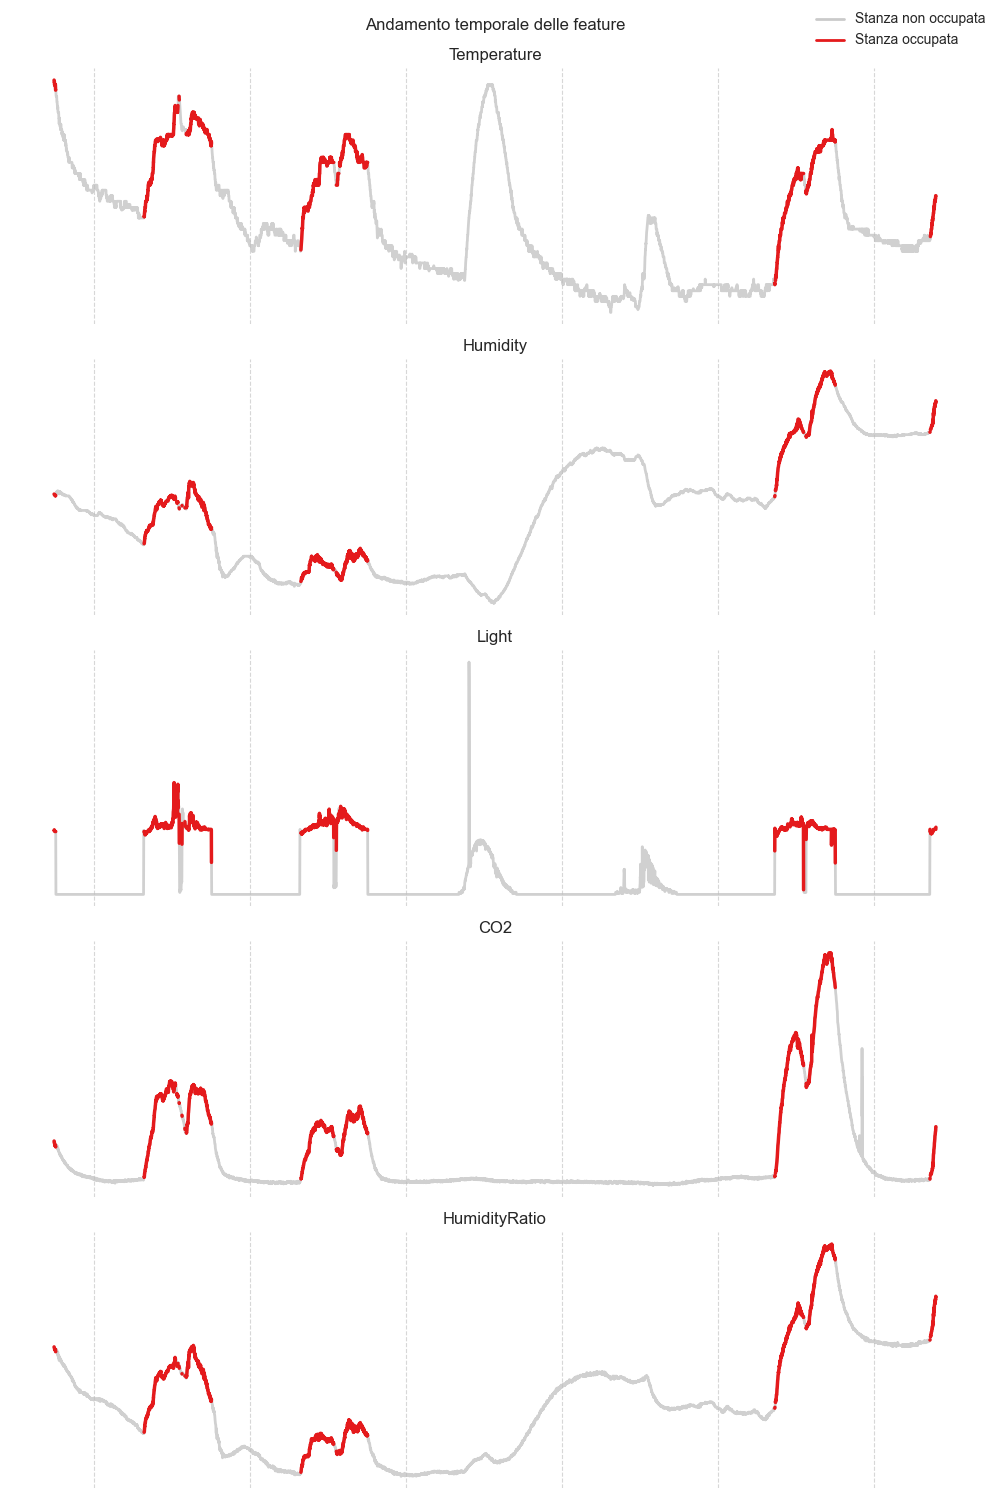

In [6]:
# stile minimale
sns.set_style('white')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# configurazione colori
grey = '#bdbdbd'
red = '#e41a1c'

# seleziona feature numeriche (escludi date, weekday, Occupancy)
features = [c for c in X.columns if c not in ['date', 'weekday', 'Occupancy']]

# layout dei subplot
n = len(features)
columns = 1
rows = math.ceil(n / columns)
fig, axes = plt.subplots(rows, columns, figsize=(10 * columns, 3 * rows), squeeze=False)
axes = axes.ravel()

for ax, feat in zip(axes, features):
    sub = X[['date', 'Occupancy', feat]].sort_values('date').dropna(subset=['date', feat])

    # disegna la serie completa in grigio
    ax.plot(sub['date'], sub[feat], color=grey, alpha=0.7, linewidth=2)

    # trova blocchi continui dove Occupancy == 1 e disegna solo quei segmenti in rosso
    mask = sub['Occupancy'] == 1
    # ogni volta che mask cambia, si crea un nuovo gruppo
    groups = mask.ne(mask.shift(fill_value=False)).cumsum()
    for _, grp in sub.groupby(groups):
        if grp['Occupancy'].iloc[0] == 1:
            ax.plot(grp['date'], grp[feat], color=red, alpha=1.0, linewidth=2.5)

    # linee verticali a mezzanotte
    days = pd.to_datetime(sub['date'].dt.normalize().unique())
    y_min, y_max = ax.get_ylim()
    for day in days:
            t = day
            if sub['date'].iloc[0] <= t <= sub['date'].iloc[-1]:
                ax.axvline(t, color=grey, linestyle='--', linewidth=0.8, alpha=0.6)

    ax.set_title(feat)
    # rimuovi bordi e tacche per uno stile minimale
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')

# legenda senza bordo
handle0 = mlines.Line2D([], [], color=grey, label='Stanza non occupata', linewidth=2, alpha=0.8)
handle1 = mlines.Line2D([], [], color=red, label='Stanza occupata', linewidth=2)
fig.legend(handles=[handle0, handle1], loc='upper right', frameon=False)
fig.suptitle('Andamento temporale delle feature', y=0.99)
plt.tight_layout()
plt.show()

Accuracy: 0.9782
ROC AUC: 0.9958
OOB score: 0.9944

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99      7703
           1       0.91      1.00      0.95      2049

    accuracy                           0.98      9752
   macro avg       0.95      0.98      0.97      9752
weighted avg       0.98      0.98      0.98      9752

Confusion matrix:
 [[7500  203]
 [  10 2039]]


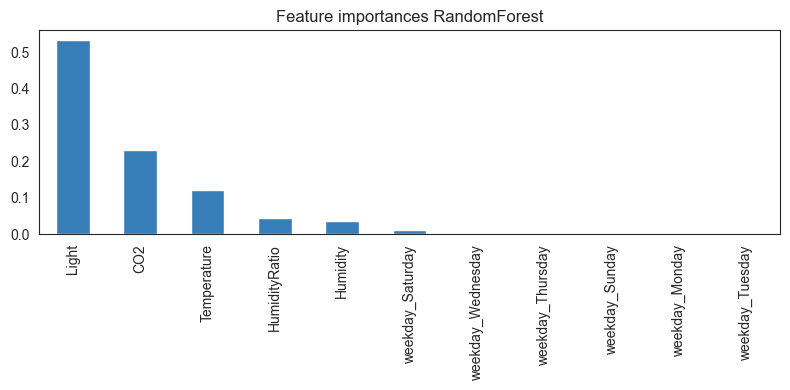

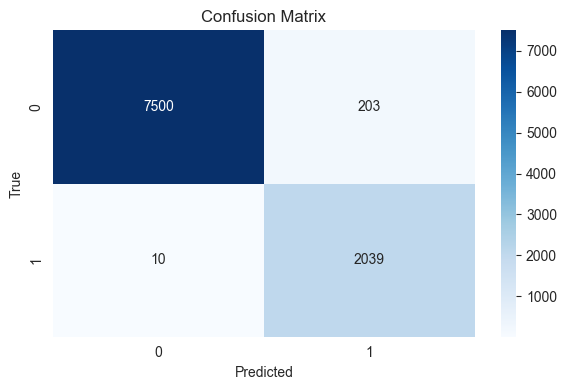

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Carica training e testing separati
X = pd.read_csv('./data/datatraining.txt')
X_t = pd.read_csv('./data/datatest2.txt')

# Normalizza la colonna date
for df_ in (X, X_t):
    df_['date'] = pd.to_datetime(df_['date'], errors='coerce')

# Preparazione training
df = X.copy()
df['weekday'] = df['date'].dt.day_name()
y_train = df['Occupancy'].astype(int)
drop_cols = ['date', 'Occupancy']
X_train_features = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Preparazione test da X_t
X_t_proc = X_t.copy()
X_t_proc['weekday'] = X_t_proc['date'].dt.day_name()
y_test = X_t_proc['Occupancy'].astype(int)
X_test_features = X_t_proc.drop(columns=[c for c in drop_cols if c in X_t_proc.columns])

# Allinea le dummy variables su training e test concatenando e poi separando
combined = pd.concat([X_train_features, X_test_features], axis=0, ignore_index=True)
combined_dummies = pd.get_dummies(combined, drop_first=True)
n_train = len(X_train_features)
X_train = combined_dummies.iloc[:n_train, :].reset_index(drop=True)
X_test = combined_dummies.iloc[n_train:, :].reset_index(drop=True)
clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=None, min_samples_split=2, oob_score=True, criterion='gini')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
if y_proba is not None and len(np.unique(y_test)) == 2:
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))
if hasattr(clf, "oob_score_"):
    print("OOB score:", round(clf.oob_score_, 4))

print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


# 5) Feature importances (plot)
importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, max(4, 0.2 * len(importances))))
importances.plot.bar(color='#377eb8')
plt.title('Feature importances RandomForest')
plt.tight_layout()
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(6, 4))

labels = clf.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [ ]:
from random import randint
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

SRC_DATASET = "./data/datatraining.txt"
FINAL_DATASET = "./data/datatest2.txt"

dataset = pd.read_csv(SRC_DATASET)
final_dataset = pd.read_csv(FINAL_DATASET)

def prepare_dataset(dataset_to_prepare):
    dataset_to_prepare["date"] = pd.to_datetime(dataset_to_prepare["date"], errors='coerce')
    dataset_to_prepare["weekday"] = dataset_to_prepare["date"].dt.weekday
    dataset_to_prepare["hour"] = dataset_to_prepare["date"].dt.round('h').dt.hour
    dataset_to_prepare = dataset_to_prepare.drop("date", axis=1)
    return dataset_to_prepare


dataset = prepare_dataset(dataset)
final_dataset = prepare_dataset(final_dataset)

# Funzione che divide il dataset in un dataset di training e uno di testing,
# dividendo in due dataset, secondo il parametro training_ratio (compreso fra 0 e 1),
# mantenendo le proporzioni del dataset iniziale (andando a campionare una frazione
# fissa di ogni gruppo dell'etichetta di classificazione)
def subsample_dataset(input_dataset, training_ratio, classification_label):
    training_dataset = (input_dataset.groupby(classification_label, group_keys=False)
                        .sample(frac=training_ratio))
    testing_dataset = input_dataset[~input_dataset.index.isin(training_dataset.index)]
    return training_dataset, testing_dataset

# Funzione che divide le features dalla verità dei fatti
def get_x_y(dataset, label):
    y = dataset[label]
    x = dataset.drop(label, axis="columns")
    return x, y


#training, testing = subsample_dataset(dataset, training_ratio=0.75, classification_label="Occupancy")

X_train, y_train = get_x_y(dataset, "Occupancy")
# X_test, y_test = get_x_y(testing, "Occupancy")

# Create a random forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Ipotizziamo dei parametri possibili per il modello e valutiamo quali siano i migliori
param_grid = {
    'n_estimators': [100, 200, 500],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 8],
    'max_samples': [0.5, 0.8],
    'max_depth': [None, 10, 30]
}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1) #usiamo 10-fold cross validation
grid_search.fit(X_train, y_train)

print("Results:", grid_search.best_estimator_.feature_importances_)
print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

rf_clf = grid_search.best_estimator_

clf = rf_clf

X_final_testing, y_final_testing = get_x_y(final_dataset, "Occupancy")

y_pred = clf.predict(X_final_testing)

confusion_matrix = pd.crosstab(y_final_testing, y_pred)

print(confusion_matrix)


plt.figure(figsize=(6, 4))
try:
    labels = clf.classes_
except Exception:
    labels = np.unique(np.concatenate([y_test, y_pred]))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, max(4, 0.2 * len(importances))))
importances.plot.bar(color='#377eb8')
plt.title('Feature importances RandomForest')
plt.tight_layout()
plt.show()



# Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
#        'Occupancy'],
#       dtype='object')
